In [ ]:
import pandas as pd
import numpy as np
import re
from collections import  Counter


import pymorphy2
from pymystem3 import Mystem
import string
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize, word_tokenize
import spacy 

nlp = spacy.load("en_core_web_sm")
morph = pymorphy2.MorphAnalyzer(lang='ru')

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [ ]:
russian_stopwords = stopwords.words("russian")
russian_stopwords = set(russian_stopwords + ['который', 'таблица', 'рисунок', 
                                             'тот', 'также', 'этот', 'это', 
                                             'такой', 'каждый', 'другой'])

def sentence_preproc(sentence):

    sentence = ''.join([ch for ch in sentence if ch not in string.punctuation])
    sentence = re.sub(r'[^а-яА-Я]', ' ', sentence).strip().replace('  ', '')
    sentence = sentence.split()

    sentence_new = [morph.parse(word)[0].normal_form for word in sentence if word not in russian_stopwords and \
                str(morph.parse(word)[0].tag) != 'UNKN']
    
    sentence_new = ' '.join(sentence_new)
        

    return sentence_new

In [ ]:
def preproc_dict_paper(dict_paper):
    dict_paper_preproc = {sentence_preproc(k):[sentence_preproc(sent) for sent in v] for k,v in dict_paper.items() \
                          if k!=''  and 'рисунок' not in k and 'таблица' not in k}
    #dict_paper_preproc.pop('')
    dict_paper_preproc = {k.replace('содержание', 'оглавление'):[sent for sent in lst_sents if sent!= ''] for k,lst_sents in dict_paper_preproc.items() \
                          if k!='' and lst_sents !='' and 'рисунок' not in k and 'таблица' not in k }
    
    
    return dict_paper_preproc

In [ ]:
df = pd.read_csv('VKR_docs_structure.csv')
df['dict_sections_texts'] = df['dict_sections_texts'].map(eval)
print('Количество текстов:', len(df))
df.head(2)

Количество текстов: 359


,title,text_paper,dict_sections_texts,faculty_department,faculty,department,degree,main_preproc_text,introduction,contents,conclusion,TZ
0,Анализ психологических типов сотрудников для м...,['Министерство науки и высшего образования Рос...,{'министерство науки и высшего образования рос...,"['ФБИТ', 'ПБКС']",ФБИТ,ПБКС,bachelor,федеральный государственный автономный образов...,В данной работе затрагивается проблема обеспеч...,Глава Основы Социальной Инженерии Как Средства...,В проведенном исследовании успешность принимае...,NONE
1,Исследование влияния алгоритма стохастического...,['Министерство науки и высшего образования Рос...,{'министерство науки и высшего образования рос...,"['ФБИТ', 'ПБКС']",ФБИТ,ПБКС,bachelor,автор бахтияров алина шамильевич фамилия имя о...,Система обнаружения вторжений СОВ это система ...,Задание на выпускную квалификационную работу А...,В ходе выполнения данной работы был произведен...,NONE


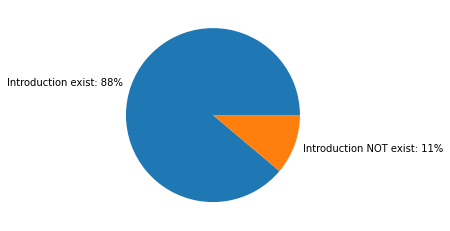

In [ ]:
p1 = len(df[df['introduction'] != 'NONE'])
p2 = len(df[df['introduction'] == 'NONE'])

y = np.array([p1, p2])
mylabels = ["Introduction exist: "+str(int((p1/(p1+p2))*100))+'%', "Introduction NOT exist: "+str(int((p2/(p1+p2))*100))+'%']

plt.pie(y, labels = mylabels)
plt.show() 

In [ ]:
df['dict_sections_texts'].values[0].keys()

dict_keys(['министерство науки и высшего образования российской федерации', 'образования', 'национальный исследовательский университет итмо', 'выпускная квалификационная работа', 'анализ психологических типов сотрудников для минимизации утечки конфиденциальной информации средствами социальной инженерии', 'фамилия имя отчество подпись', 'бакалавр магистр', 'к защите допустить', 'фамилия и.о. ученое звание степень подпись', 'санктпетербург г.', 'фио подпись', 'министерство науки и высшего образования российской федерации федеральное государственное автономное образовательное учреждение высшего образования', 'задание', 'на выпускную квалификационную работу', 'аннотация', 'выпускной квалификационной работы', 'характеристика выпускной квалификационной работы', 'библиографическое описание публикаций', 'содержание', 'введение', 'выводы', 'заключение', 'актуальность выбранной проблематики связана с тем что взаимодействие специалиста по обеспечению защиты данных с сотрудниками имеющими к ним до

In [ ]:
df['dict_sections_texts'].values[0]

{'министерство науки и высшего образования российской федерации': 'Федеральное Государственное Автономное Образовательное Учреждение Высшего',
 'образования': 'НАЦИОНАЛЬНЫЙ Исследовательский Университет ИТМО',
 'национальный исследовательский университет итмо': 'Утверждаю Руководитель Оп Канжелев Ю.а. Фамилия И.О. подпись декабря  г.',
 'выпускная квалификационная работа': '',
 'анализ психологических типов сотрудников для минимизации утечки конфиденциальной информации средствами социальной инженерии': 'Автор Иванова Александра Сергеевна',
 'фамилия имя отчество подпись': 'Направление подготовки специальность.. код наименование Информационная безопасность Квалификация бакалавр',
 'бакалавр магистр': 'Руководитель Вкр Канжелев Ю.А. к.т.н. с.н.с. Фамилия И. О. ученое звание степень Подпись',
 'к защите допустить': 'Руководитель Оп. Канжелев Ю.А. к.т.н. с.н.с.',
 'фамилия и.о. ученое звание степень подпись': 'мая  г.',
 'санктпетербург г.': 'Обучающийся Иванова А.С.Группа Факультет Бит Фа

In [ ]:
text = 'Статья Актуальные киберугрозы  тренды и прогнозы. Электронный ресурс    с.. дата обращения.. Статья Актуальные киберугрозы итоги года. Электронный ресурс    с.. дата обращения...  Электронный ресурсю.. дата обращения.. Кабанов А.С. Лось А.Б. Суроев А.в. Методы социальной инженерии в сфере информационной безопасности и противодействие им Электронный ресурс Кабанов А.С. Лось А.Б. Суроев А.в..  Ьйротраслиправа.рфагНсе дата обращения.. Домарев В. В. Безопасность информационных технологий. Системный подходВ.В. Домарев К. Ооо Тид Диа Софт.  с. ил. Тип Книга Год Кевин Д. Митник Вильям Л. Саймон. Искусство обмана. Электронный ресурс Кевин Д. М. Вильям Л. С.. дата обращения.. Халявин В. Секретная книга пиратаХалявин В. М. Мартин. с. Тип Книга Год Гл. редакция Л. Ф. Ильичв П. Н. Федосеев С. М. Ковалв В. Г. Панов. Философский энциклопедический словарь Электронный ресурс М. Советская энциклопедия... обращения.. Студия О звучания. что это такое детальный разбор Электронный ресурсСтудия О звучания.. дата обращения.. Лобель Т. Теплая чашка в холодный день. Как физические ощущения влияют на наши решения Лобель Т. М. Альпина Паблишер. Тип Книга Год Гафарова Я.К. Герасимов В.В. Гарипов И.м. Социальная инженерия Научное сообщество студентов Междисциплинарные исследования сб. ст. по мат. междунар. студ. науч.практ. конф.... дата обращения... Берн Э. Игры в которые играют люди. Люди которые играют в игры пер. с англ. А. Грузберга. М. Эксмо.  с. Психология общения. Трунова А. А. Анализ каналов утечки конфиденциальной информации в информационных системах предприятий А. А. Трунова. Электронный ресурс Молодой ученый... С... дата обращения... Директор по персоналу. Практический журнал по управлению человеческими ресурсами. Баскетметод как способ оценки и обучения Электронный ресурс актион Кадры и.. дата обращения.. Чалдини Р. Психология влияния. Убеждай воздействуй защищайся. СПб. Питер.  с. Ананьин Е. В. Кожевникова И. С. Лысенко А. В. Никишова А. В. Мартынова Л. Е. Назарова К. Е. Попков С. М. Белозрова А. А. Основные виды атак социальной инженерии Молодой ученый... С. Тип Статья Год. Маклаков А.г. Общая психология. СПб. Питер.  с. Учебник нового века.'

In [ ]:
lst_section_symbols_count = []
for dst in df['dict_sections_texts']:
    lst_section_symbols_count = lst_section_symbols_count + [len(v) for v in dst.values()]
print(len(lst_section_symbols_count))  
print(len(set(lst_section_symbols_count)))

13650
2997


<AxesSubplot:ylabel='Density'>

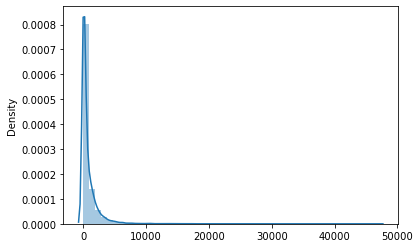

In [ ]:
sns.distplot(lst_section_symbols_count)

##### Popular sections

In [ ]:
lst_sections_keys = []
for dst in df['dict_sections_texts']:
    lst_sections_keys = lst_sections_keys + list(dst.keys())
print(len(lst_sections_keys))  
print(len(set(lst_sections_keys)))

df_count_sections = pd.DataFrame()
df_count_sections['section_name'] = list(set(lst_sections_keys))
df_count_sections = df_count_sections[df_count_sections['section_name'] != '']
df_count_sections['count_words_section_name'] = df_count_sections['section_name'].apply(lambda x: len(x.split()))
df_count_sections['count_symb_section_name'] = df_count_sections['section_name'].apply(lambda x: len(x))
df_count_sections['count'] = df_count_sections['section_name'].map(Counter(lst_sections_keys))
df_count_sections = df_count_sections[df_count_sections['count_symb_section_name'] > 2]
df_count_sections = df_count_sections.sort_values(by = 'count', ascending=False)
print(len(df_count_sections))
df_count_sections.head()

13650
6609
6528


,section_name,count_words_section_name,count_symb_section_name,count
211,аннотация,1,9,355
1270,выпускной квалификационной работы,3,33,354
2396,выпускная квалификационная работа,3,33,351
4370,задание,1,7,348
478,на выпускную квалификационную работу,4,36,345


<AxesSubplot:xlabel='count', ylabel='Density'>

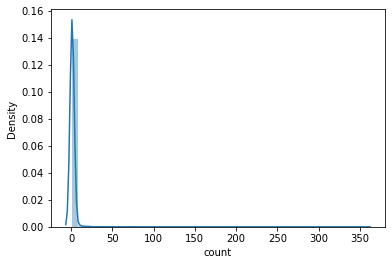

In [ ]:
sns.distplot(df_count_sections['count'])

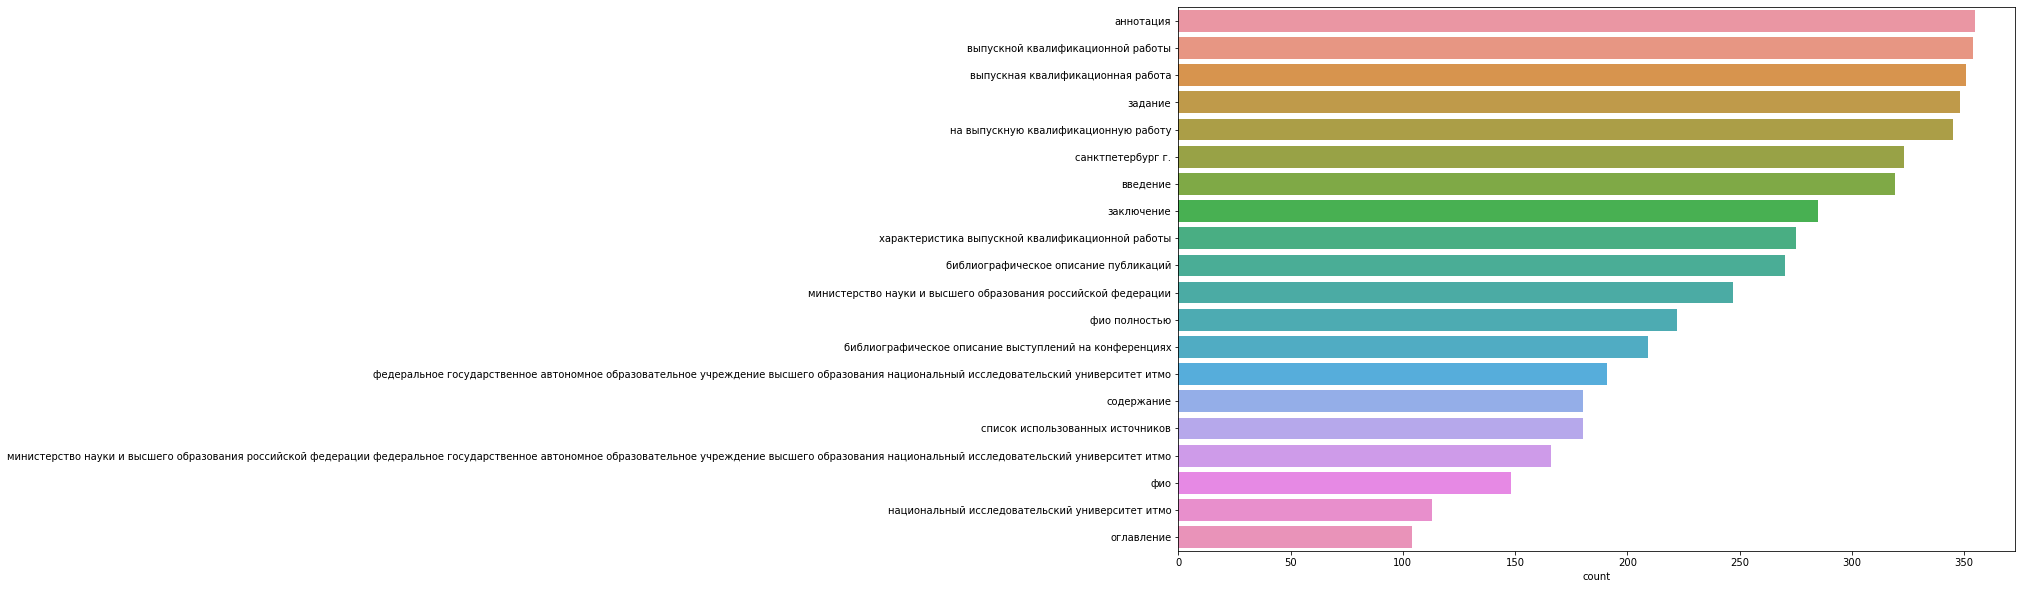

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(y=lst_sections_keys, order=df_count_sections['section_name'].values[:20])
plt.show()

Wall time: 14min 52s


<AxesSubplot:xlabel='corr_sections_and_intro', ylabel='Density'>

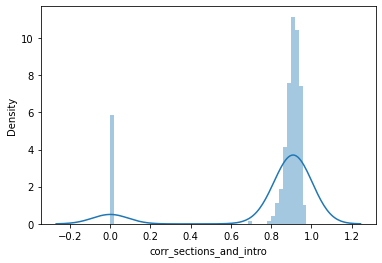

In [ ]:
%%time

def get_info_corr_sections_and_intro(paper_dict):
    if 'введение' not in paper_dict:
        return 0, {}
    intro_preproc = sentence_preproc(paper_dict['введение'])

    dict_intro_parag_corr = {}
    for parag_name in paper_dict.keys():
        if 'введение' in parag_name:
            continue
        parag_text = paper_dict[parag_name]
        if len(parag_text) < 30:
            continue
            
        parag_preproc = sentence_preproc(parag_text)

        doc_intro = nlp(intro_preproc)
        doc_parag = nlp(parag_preproc)
        corr = doc_parag.similarity(doc_intro)
        dict_intro_parag_corr[parag_name] = corr
        
    avg_corr_sections_and_intro = np.mean(list(dict_intro_parag_corr.values()))    
    return avg_corr_sections_and_intro, dict_intro_parag_corr



df['si_corr_info'] = df['dict_sections_texts'].map(get_info_corr_sections_and_intro)
df['corr_sections_and_intro'] = df['si_corr_info'].apply(lambda x: x[0])
sns.distplot(df['corr_sections_and_intro'])

In [ ]:
df.to_csv('VKR_docs_info.csv', index = False)